In [1]:
from bfiw_reg.registrar import BFIWReg
import cv2
import numpy as np
import os
import imageio
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import re

In [2]:
import h5py

filename = "/storage/valis_reg/segmentation_masks/1202_msrcr_Simple Segmentation.h5"

def read_h5_mask(filename):
    with h5py.File(filename, "r") as f:
        data = f['exported_data']
        data = np.squeeze(np.array(data), axis=-1)
    return data


mask = read_h5_mask(filename)

In [3]:
import re

bfi_regex = re.compile(r'B_244-ST_BFI-SE_(\d+).jpg')
bfiw_regex = re.compile(r'B_244-ST_BFIW-SE_(\d+).jpg')

## Read all the Cropped Retinex and Cropped Original Images

In [4]:
bfi_path = '244_BFIW/BFI'
bfiw_path = '244_BFIW/BFIW'

bfi = {bfi_regex.match(f).group(1).zfill(4): imageio.imread_v2(os.path.join(bfi_path, f)) for f in tqdm(os.listdir(bfi_path)) if f.endswith('.jpg')}
bfiw = {bfiw_regex.match(f).group(1).zfill(4): imageio.imread_v2(os.path.join(bfiw_path, f)) for f in tqdm(os.listdir(bfiw_path)) if f.endswith('.jpg')} 
# Cropped
bfi_imgs = {f.split('.')[0]: imageio.imread_v2(os.path.join('/storage/valis_reg/244_BFI_reg_multi/BFI/bfi_original', f)) for f in tqdm(sorted(os.listdir('/storage/valis_reg/244_BFI_reg_multi/BFI/bfi_original')))}
bfiw_imgs = {f.split('.')[0]: imageio.imread_v2(os.path.join('/storage/valis_reg/244_BFI_reg_multi/BFI/bfiw_original', f)) for f in tqdm(sorted(os.listdir('/storage/valis_reg/244_BFI_reg_multi/BFI/bfiw_original')))}
bfi_msr_imgs = {f.split('_')[0]: imageio.imread_v2(os.path.join('/storage/valis_reg/244_BFI_reg_multi/BFI/bfi_msr', f)) for f in tqdm(sorted(os.listdir('/storage/valis_reg/244_BFI_reg_multi/BFI/bfi_msr')))}
bfiw_msr_imgs = {f.split('_')[0]: imageio.imread_v2(os.path.join('/storage/valis_reg/244_BFI_reg_multi/BFI/bfiw_msr', f)) for f in tqdm(sorted(os.listdir('/storage/valis_reg/244_BFI_reg_multi/BFI/bfiw_msr')))}
segmentation_dir = '/storage/valis_reg/segmentation_masks'
segmentation_masks = {f.split('_')[0]: read_h5_mask(os.path.join(segmentation_dir, f)) for f in tqdm(sorted(os.listdir(segmentation_dir)))}

100%|██████████| 2496/2496 [01:33<00:00, 26.78it/s]


(-0.5, 3087.5, 2075.5, -0.5)

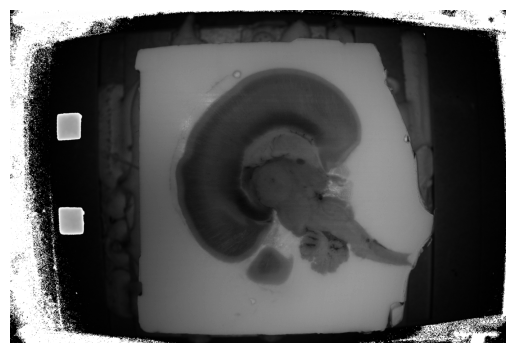

In [5]:
sample_bfi = bfi['1202']
sample_bfiw = bfiw['1202']

sample_bfi_gray = cv2.cvtColor(sample_bfi, cv2.COLOR_RGB2GRAY)
sample_bfiw_gray = cv2.cvtColor(sample_bfiw, cv2.COLOR_RGB2GRAY)

plt.imshow(sample_bfiw_gray - sample_bfi_gray, cmap='gray')
plt.axis('off')


[  9 232]


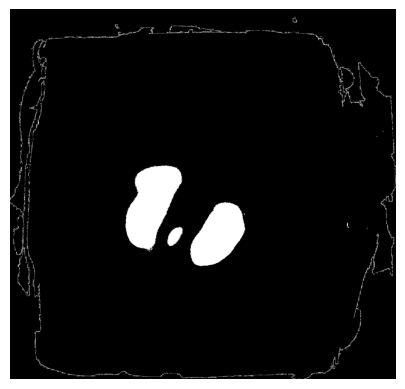

In [131]:
from skimage.filters import threshold_multiotsu
slide_idx = '2600'
img_bfi = bfi_imgs[slide_idx]
img_bfiw = bfiw_imgs[slide_idx]

img_bfi_msr = bfi_msr_imgs[slide_idx]
img_bfiw_msr = bfiw_msr_imgs[slide_idx]

bfi_mask10 = img_bfi[:,:,1] - img_bfi[:,:,0]
bfi_mask20 = img_bfi[:,:,2] - img_bfi[:,:,0]
bfi_1 = img_bfi[:,:,1]
bfi_0 = img_bfi[:,:,0]
bfi_2 = img_bfi[:,:,2]
# invert bfi_1
bfi_1_inv = bfi_1.max() - bfi_1
bfi_0_inv = bfi_0.max() - bfi_0
bfi_2_inv = bfi_2.max() - bfi_2
# plt.imshow(bfi_0_inv, cmap='gray')
thresholds = threshold_multiotsu(bfi_1_inv, classes=3)
print(thresholds)
# Anything that is pure white is not needed
bfi_0_inv[bfi_0_inv > threshold_multiotsu(bfi_0_inv, classes=3)[-1]] = 0
bfi_1_inv[bfi_1_inv > threshold_multiotsu(bfi_0_inv, classes=3)[-1]] = 0
bfi_2_inv[bfi_2_inv > threshold_multiotsu(bfi_0_inv, classes=3)[-1]] = 0
tipping_point = threshold_multiotsu(bfi_mask10, classes=3)[-1]
bfi_mask10[bfi_mask10 > tipping_point] = 255
bfi_mask10[bfi_mask10 <= tipping_point] = 0
_, bfi_mask10 = cv2.threshold(bfi_1_inv, 0, 255, cv2.THRESH_BINARY)
# plt.imshow(bfi_mask10, cmap='gray')
# plt.imshow(bfi_2_inv, cmap='gray')
# Multi-Otsu thresholding


# regions = np.digitize(bfi_0_inv, bins=thresholds)
# plt.imshow(regions, cmap='gray')
# plt.imshow(bfi_1_inv, cmap='gray')

# plt.imshow(img_bfi[:,:,1]  , cmap='gray')
# bfi_mask10 = cv2.morphologyEx(bfi_mask10, cv2.MORPH_HITMISS, np.ones((3,3)), iterations=2)
# bfi_mask10 = cv2.morphologyEx(bfi_mask10, cv2.MORPH_DILATE, np.ones((3,3)), iterations=2)
# bfi_mask10 = cv2.morphologyEx(bfi_mask10, cv2.MORPH_CLOSE, np.ones((3,3)), iterations=2)
# print(threshold_multiotsu(bfi_mask10, classes=2))
# bfi_mask10 = cv2.GaussianBlur(img_bfi, (7,7), sigmaX=5, sigmaY=5)
plt.imshow(bfi_mask10, cmap='gray')
plt.axis('off')
plt.show()

In [86]:
bfi_mask10 = cv2.dilate(bfi_mask10, np.ones((3,3), np.uint8), iterations=1)
np.unique(bfi_mask10)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255], dtype=uint8)

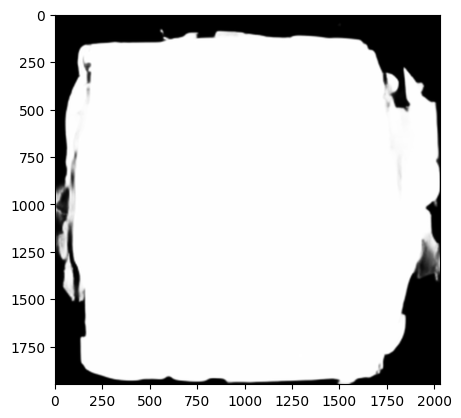

In [133]:
plt.imshow(mask, cmap='gray')

In [ ]:
# fig, ax = plt.subplots(len(ret_imgs), 3, figsize=(30, 30))

# for i, img in enumerate(ret_imgs):
#     for j in range(3):
#         img_ = img[:,:,j]
#         ax[i][j].imshow(img_, cmap='gray')
#         ax[i][j].axis('off')
#         ax[i][j].set_title(f'Image {i}:Channel {j}')
# plt.show()
fig, ax = plt.subplots(len(ret_imgs), 1, figsize=(30, 30))
for i, img in enumerate(ret_imgs):
    img__ = np.abs(np.mean(img[:,:,:], axis=2)-img[:,:,1])
    img__[img__>2]=255
    ax[i].imshow(img__, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Image {i}:Channel 2-1')
    # ret_imgs[i] = 255-np.abs(np.mean(img[:,:,1:], axis=2)-img[:,:,0])




In [78]:
# Sort BFI

bfi = dict(sorted(bfi.items(), key=lambda x: x[0]))
bfiw = dict(sorted(bfiw.items(), key=lambda x: x[0]))


In [ ]:
plt.imshow(bfiw['1202'])

In [88]:
eps = np.finfo(np.float32).eps

In [ ]:
img_bfiw = bfiw['1202'].copy()
img_bfi = bfi['1202'].copy()
darkfield = bfi['2677'].copy()
brightfield = bfiw['2677'].copy()
# img_bfiw = cv2.cvtColor(img_bfiw, cv2.COLOR_RGB2LAB)
# img_bfi = cv2.cvtColor(img_bfi, cv2.COLOR_RGB2LAB)

Corrected_Image = ((img_bfiw - darkfield) / (brightfield - darkfield + eps)) * 255
Corrected_Image = (Corrected_Image - np.min(Corrected_Image))/ (np.max(Corrected_Image) - np.min(Corrected_Image))


channel_id = 2
# img_bfiw_channel = np.std(img_bfiw[:,:,:].copy(), axis=-1)
# img_bfiw_channel = np.std(img_bfiw[:,:,channel_id].copy(), axis=-1)
img_bfiw_channel = img_bfiw[:,:,channel_id].copy()
img_bfi_channel =  img_bfi[:,:,channel_id].copy()
# img_bfi_channel = np.std(img_bfi[:,:,channel_id].copy(), axis=-1)
# img_bfi_channel = np.std(img_bfi[:,:,:].copy(), axis=-1)

img_bfiw_channel = -np.log10((img_bfiw_channel+eps)/np.max(img_bfiw_channel))
img_bfi_channel = -np.log10((img_bfi_channel+eps)/np.max(img_bfi_channel))

img_bfiw_channel[img_bfiw_channel<0] = 0
img_bfi_channel[img_bfi_channel<0] = 0

img_bfi_channel = (img_bfi_channel - np.min(img_bfi_channel))/ (np.max(img_bfi_channel) - np.min(img_bfi_channel))
img_bfiw_channel = (img_bfiw_channel - np.min(img_bfiw_channel))/ (np.max(img_bfiw_channel) - np.min(img_bfiw_channel))
fig, ax = plt.subplots(1, 4, figsize=(40, 40))
ax[0].imshow(img_bfiw_channel, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'BFIW {np.min(img_bfiw_channel)} { np.max(img_bfiw_channel)}')
ax[1].imshow(img_bfi_channel, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'BFI {np.min(img_bfi_channel)} { np.max(img_bfi_channel)}')
ax[2].imshow(img_bfi_channel/img_bfiw_channel, cmap='gray')
ax[2].axis('off')
ax[2].set_title(f'BFI* BFIW {np.min(img_bfi_channel)} { np.max(img_bfi_channel)}')
ax[3].imshow(img_bfiw - darkfield, cmap='gray')
ax[3].axis('off')
ax[3].set_title(f'Corrected Image {np.min(Corrected_Image)} { np.max(Corrected_Image)}')
plt.show()



In [ ]:
# plt.imshow( np.max(3*img_bfiw - 2*img_bfi, axis=-1))

def convert_RGB_to_OD(I):
    """
    Convert from RGB to optical density (OD_RGB) space.

    RGB = 255 * exp(-1*OD_RGB).

    :param I: Image RGB uint8.
    :return: Optical denisty RGB image.
    """
    mask = (I == 0)
    I[mask] = 1
    return np.maximum(-1 * np.log(I / 255), 1e-6)


img_bfiw_gray = cv2.cvtColor(img_bfiw, cv2.COLOR_RGB2GRAY)
img_bfiw_gray = img_bfiw[:,:,0]
img_bfi_gray = cv2.cvtColor(img_bfi, cv2.COLOR_RGB2GRAY)

def background_removal_dog(brightfield_img, kernel1=15, kernel2=25):
    """Remove background using the Difference of Gaussian (DoG) method."""
    # Apply Gaussian blur with two different kernel sizes
    blurred1 = cv2.GaussianBlur(brightfield_img, (kernel1, kernel1), 0)
    blurred2 = cv2.GaussianBlur(brightfield_img, (kernel2, kernel2), 0)
    
    # Subtract the two blurred images (Difference of Gaussians)
    dog_result = blurred1 - blurred2
    
    # Threshold to isolate the foreground
    _, binarized_foreground = cv2.threshold(dog_result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    
    return binarized_foreground

bg = background_removal_dog(img_bfiw_gray, kernel1=23, kernel2=45)

plt.imshow(convert_RGB_to_OD(img_bfiw_gray), cmap='gray')
# np.percentile(255 - np.mean(img_bfiw - brightfield, axis=-1), np.linspace(0,100,11))

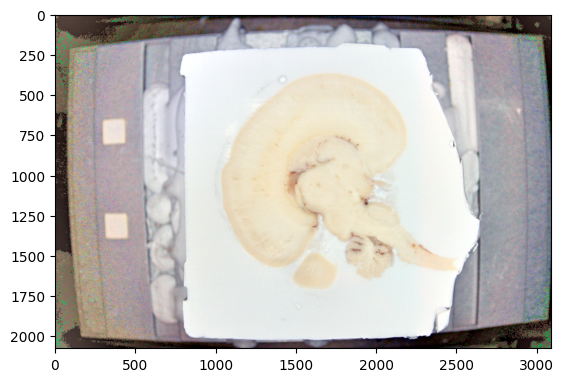

In [4]:
from bfiw_reg.retinex import msrcr

img_bfiw = bfiw['1202'].copy()
img_bfi = bfi['1202'].copy()

img_bfi_retinex = msrcr(img_bfi)
img_bfiw_retinex = msrcr(img_bfiw)

plt.imshow(img_bfi_retinex, alpha=0.3)
plt.imshow(img_bfiw_retinex)

In [14]:
import skimage.filters
import skimage.restoration
import skimage.util

# hess_img = skimage.filters.hessian(img_bfiw_retinex)
roll_ball_img = skimage.restoration.rolling_ball(skimage.util.invert(np.mean(img_bfiw,axis=-1)), radius=50)

In [17]:
import h5py

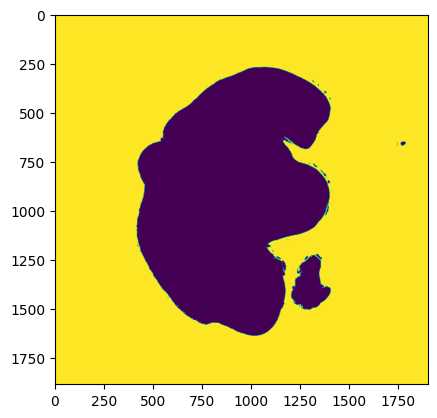

In [27]:
plt.imshow(mask)

100%|██████████| 2496/2496 [01:51<00:00, 22.29it/s]


In [83]:
dest_dir = '244_processed'
dest_msrcr_dir = os.path.join(dest_dir , 'msrcr')
dest_orig_dir = os.path.join(dest_dir , 'original')
os.makedirs(dest_msrcr_dir, exist_ok=True)
os.makedirs(dest_orig_dir, exist_ok=True)

In [84]:
for slide_idx in tqdm(retinex_imgs.keys()):
    if slide_idx == '2434':
        continue
    retinex_masked_out = cv2.bitwise_and(retinex_imgs[slide_idx].copy(), retinex_imgs[slide_idx].copy(), mask=((1-segmentation_masks[slide_idx])==0).astype(np.uint8))
    # masked_out = cv2.cvtColor(masked_out, cv2.COLOR_RGB2GRAY)
    retinex_masked_out[retinex_masked_out==0] = 255
    original_masked_out = cv2.bitwise_and(orig_imgs[slide_idx].copy(), orig_imgs[slide_idx].copy(), mask=((1-segmentation_masks[slide_idx])==0).astype(np.uint8))
    # masked_out = cv2.cvtColor(masked_out, cv2.COLOR_RGB2GRAY)
    original_masked_out[original_masked_out==0] = 255
    imageio.imwrite(os.path.join(dest_msrcr_dir, f'{slide_idx}.jpg'), retinex_masked_out)
    imageio.imwrite(os.path.join(dest_orig_dir, f'{slide_idx}.jpg'), original_masked_out)


100%|██████████| 2496/2496 [02:25<00:00, 17.16it/s]


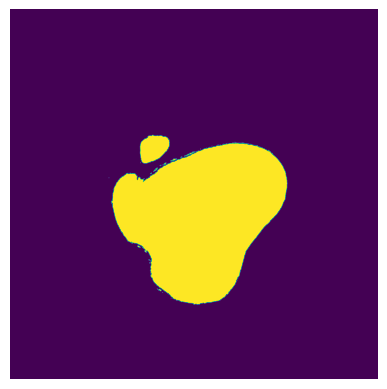

In [72]:
plt.imshow(((1-segmentation_masks[slide_idx])==0).astype(np.uint8))
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Segmentation Mask 0 255')

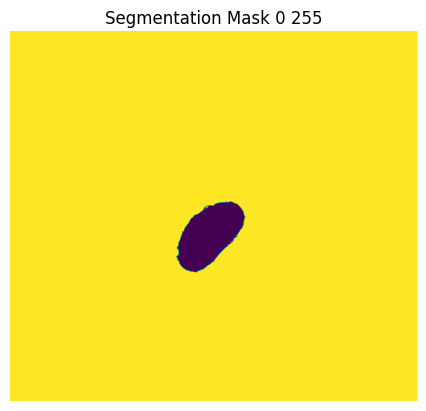

In [51]:
plt.imshow((1-segmentation_masks['0022']))
plt.axis('off')
plt.title(f'Segmentation Mask {np.min(1-segmentation_masks["0022"])} {np.max(1-segmentation_masks["0022"])}')

In [76]:
os.makedirs('non_segmented', exist_ok=True)

for slide_idx in tqdm(retinex_imgs.keys()):
    if slide_idx imwrite(os.path.join('non_segmented', f'{slide_idx}_msrc.jpg'), retinex_imgs[slide_idx])

100%|██████████| 2496/2496 [00:13<00:00, 180.00it/s]


In [ ]:
dest_msrcr_dir = os.path.join(dest_dir , 'msrcr')


In [5]:
img_bfiw = bfiw['1202'].copy()
img_bfi = bfi['1202'].copy()

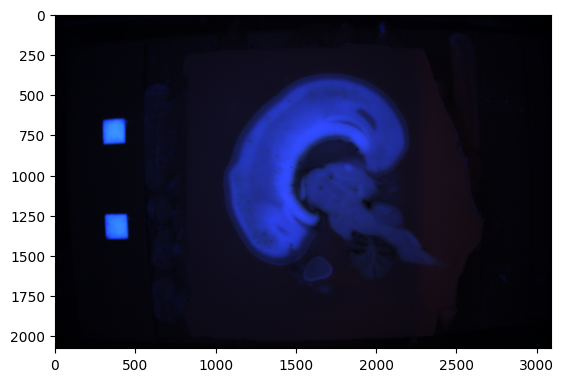

In [108]:
img_bfi = bfi['1252'].copy()
plt.imshow(img_bfi)

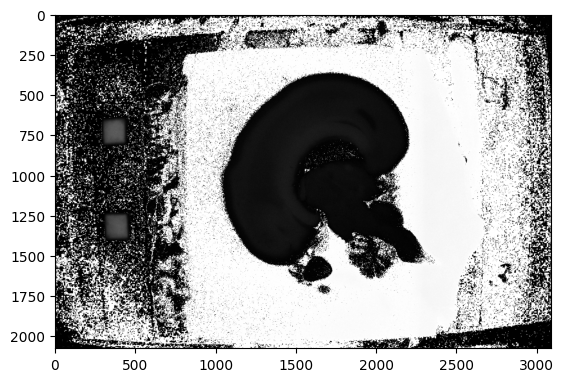

In [109]:

plt.imshow((img_bfi[:,:,1]-img_bfi[:,:,0]), cmap='gray')

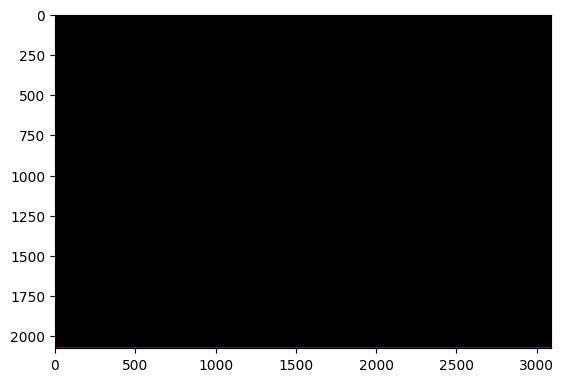

In [34]:
contours, _ = cv2.findContours(img_bfi[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
blank = np.zeros_like(img_bfi)
cv2.drawContours(blank, contours, -1, (255, 255, 255), 1)
plt.imshow(img_bfi[:,:,0], cmap='gray')
# CLAHE (Contrast Limited Adaptive Histogram Equalization)  
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_bfi_clahe = clahe.apply(img_bfi[:,:,2].copy())
# plt.imshow(img_bfi_clahe, cmap='gray')
contours, _ = cv2.findContours(img_bfi_clahe, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blank = np.zeros_like(img_bfi)
blank = cv2.drawContours(blank, contours, -1, (255, 0, 0), 5)
plt.imshow(blank, cmap='gray')

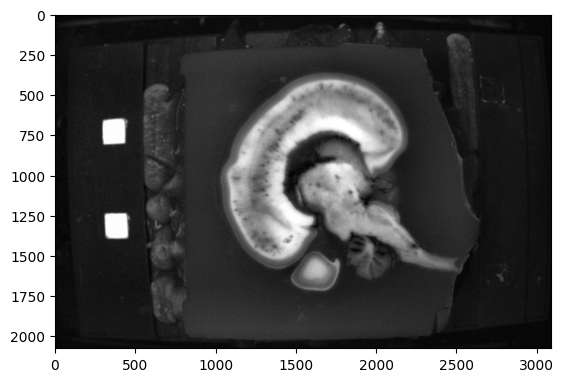

In [37]:
# plt.imshow(img_bfi_clahe, cmap='gray')
norm_img = cv2.normalize(img_bfi_clahe, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(norm_img, cmap='gray')

In [134]:
import numpy as np
import json
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import cv2
import shutil
from tqdm import tqdm, trange
import scipy.ndimage as ndimage


retinex_imgs = [cv2.imread(f'/storage/valis_reg/244_processed/msrcr/{img}', cv2.IMREAD_GRAYSCALE) for img in tqdm(sorted(os.listdir('/storage/valis_reg/244_processed/msrcr/')))]


100%|██████████| 2495/2495 [00:55<00:00, 44.68it/s]


In [135]:
largest_r = 0
largest_c = 0
for img in retinex_imgs:
    r, c = img.shape
    if r > largest_r:
        largest_r = r
    if c > largest_c:
        largest_c = c


def pad_img_gray(img, r, c):
    padded_img = np.ones((r, c))*255
    padded_img[:img.shape[0], :img.shape[1]] = img
    return padded_img

def pad_img_color(img, r, c):
    padded_img = np.ones((r, c, 3))*255
    padded_img[:img.shape[0], :img.shape[1], :] = img
    return padded_img

def pad_img(img, r, c):
    if len(img.shape) == 2:
        return pad_img_gray(img, r, c)
    else:
        return pad_img_color(img, r, c)


retinex_imgs = [pad_img(img, largest_r, largest_c) for img in tqdm(retinex_imgs)]

100%|██████████| 2495/2495 [02:09<00:00, 19.32it/s]


In [136]:
import SimpleITK as sitk
import numpy as np

images = [sitk.GetImageFromArray(img) for img in tqdm(retinex_imgs)]

100%|██████████| 2495/2495 [00:30<00:00, 82.83it/s]


In [137]:
# Initialize the registration method
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings (you can also try other metrics like Mattes Mutual Information)
registration_method.SetMetricAsMeanSquares()

# Interpolator settings
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings
registration_method.SetOptimizerAsRegularStepGradientDescent(
    learningRate=4.0,       # Adjusted learning rate
    minStep=1e-4,
    numberOfIterations=100,  # Fewer iterations since the parameter space is smaller
    gradientMagnitudeTolerance=1e-8
)

# List to store the cumulative transforms
transforms = []

# Use the first image as the reference (fixed image)
fixed_image = images[0]

# Start with the identity transform for the first image
identity_transform = sitk.Transform(fixed_image.GetDimension(), sitk.sitkIdentity)
transforms.append(identity_transform)

# Perform serial registration
for i in trange(1, len(images)):
    moving_image = images[i]
    try:

        # Initialize the transform for translation only
        initial_transform = sitk.TranslationTransform(fixed_image.GetDimension())
        registration_method.SetInitialTransform(initial_transform, inPlace=False)

        # Execute the registration
        final_transform = registration_method.Execute(fixed_image, moving_image)
        #  Cast the final transform to TranslationTransform
        # final_transform = sitk.TranslationTransform(final_transform)
        previous_parameters = transforms[-1].GetParameters()
        current_parameters = final_transform.GetParameters()
        if len(transforms[-1].GetParameters()) ==0 :
            previous_parameters = (0,0)
        cumulative_parameters = [p + c for p, c in zip(previous_parameters, current_parameters)]
        # Create a new translation transform with the cumulative parameters
        cumulative_transform = sitk.TranslationTransform(fixed_image.GetDimension())
        cumulative_transform.SetParameters(cumulative_parameters)
        transforms.append(cumulative_transform)
    except Exception as e:
        print(f'Error in slide {i}')
        transforms.append(transforms[-1])
        continue
    fixed_image = moving_image

 38%|███▊      | 959/2494 [20:33<33:29,  1.31s/it]  

In [ ]:
import pickle 
os.makedirs('sitk_combined', exist_ok=True)
output_dir = 'sitk_combined'
with open(f'{output_dir}/transforms.pkl', 'wb') as f:
    pickle.dump(transforms, f)

In [ ]:



# Resample images using cumulative transforms
registered_images = []
for i, (image, transform) in enumerate(zip(images, transforms)):
    resampled_image = sitk.Resample(
        image,
        images[0],
        transform,
        sitk.sitkLinear,
        255.0,
        image.GetPixelID()
    )
    registered_images.append(resampled_image)

In [ ]:
# Combine the registered images into a 3D volume
if fixed_image.GetDimension() == 2:
    # Stack 2D images into a 3D volume
    volume = sitk.JoinSeries(registered_images)

    # Set the correct spacing for the volume (assuming uniform spacing between slices)
    slice_thickness = 1.0  # Replace with actual slice thickness if known
    spacing = list(fixed_image.GetSpacing()) + [slice_thickness]
    volume.SetSpacing(spacing)

    # Optionally, set the origin and direction
    origin = list(fixed_image.GetOrigin()) + [0.0]
    volume.SetOrigin(origin)

    direction = list(fixed_image.GetDirection())
    direction.extend([0]*len(direction))
    direction.extend([0]*(len(direction)//2))
    direction.append(1.0)
    # volume.SetDirection(direction)

    # Save the combined volume
    volume_output_path = os.path.join(output_dir, "registered_volume.nii.gz")
    sitk.WriteImage(volume, volume_output_path)
    print(f"Saved registered volume to {volume_output_path}")
else:
    print("Images are not 2D. Skipping volume construction.")